# Example 2.4-5

From Parameter Estimation and Inverse Problems, 3rd edition, 2018    
by R. Aster, B. Borchers, C. Thurber

## Implemented in Python by:
* Nima Nooshiri [@nimanzik](https://github.com/nimanzik)

---

In [1]:
%reset -f

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import linalg as sla, stats

from peiplib.solve import irls

In [3]:
plt.style.use('ggplot')
plt.style.use('./data/peiplib.mplstyle')

---

## Example 2.4

In this example, we demonstrate the advantages of 1-norm minimization using the quadratic
ballistics regression example discussed earlier.

## Synthetic Data Set
First, we load precomputed data. Then, we introduce on of the points ($d_4$) as an outlier:

In [4]:
# Load precomputed data
matdata = loadmat('./data/data1.mat', squeeze_me=True)
t, y, sigma = matdata['data1'].T
n_obs = t.size

# Outlier
y[3] -= 200.0

print('Display data: t, y and sigma')
t, y, sigma

Display data: t, y and sigma


(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([109.3827, 187.5385, 267.5319, 131.8753, 386.0535, 428.4271,
        452.1644, 498.1461, 512.3499, 512.9753]),
 array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]))

## L2 Regression (Least-Squares Solutions)

In [5]:
# Build the parabolic system matrix
G = np.array([np.ones_like(t), t, -0.5 * t**2]).T

# Apply the weighting
W = np.identity(n_obs) / sigma
yw = W @ y
Gw = W @ G

# Solve for the least-squares solution
m_L2 = np.linalg.inv(Gw.T @ Gw) @ Gw.T @ yw

print('Least-squares solution:')
m_L2

Least-squares solution:


array([26.41740833, 75.6040222 ,  4.86208106])

## L1 Regression

In [6]:
m_L1 = irls(Gw, yw, eps=1.0e-5, tau=1.0e-5, p=1, n_iter=250)

print('1-norm solutions:')
m_L1

1-norm solutions:


array([17.13078685, 96.99237011,  9.4809922 ])

Figure below compares L1 (solid) and L2 (dashed) solutions for a parabolic data set with an outlier at `t=4` s.

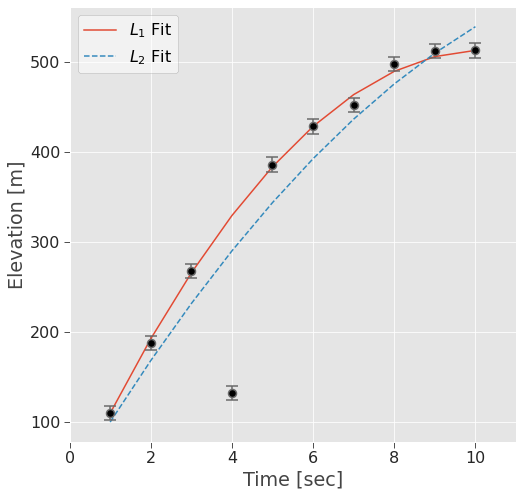

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(t, G @ m_L1, '-', label='$L_1$ Fit')
ax.plot(t, G @ m_L2, '--', label='$L_2$ Fit')

ax.errorbar(
    t, y, yerr=sigma, marker='o', linestyle='none', markerfacecolor='k',
    markeredgecolor='dimgray', ecolor='dimgray', capsize=6)

ax.set(xlim=(0, 11), xlabel='Time [sec]', ylabel='Elevation [m]')
ax.legend();

---

## Example 2.5
## Monte-Carlo Error Propagation

In [8]:
def helper_MonteCarlo_errorprop(G, m_L1, sigma, n_real=100):
    """
    This function is using Monte Carlo error propagation technique for
    empirical estimation of covariance matrix of model parameters estimated
    by IRLS algorithm.
    
    Parameters
    ----------
    G : array-like
        Representation of m-by-n system matrix (i.e. forward operator).
    m_L1 : array-like
        1-norm solution to Gm=d system of equations.
    sigma : float or array-like
        Standard deviation of data errors.
    n_real: int, optional
        Number of realisations of the Monte-Carlo procedure. Default is 100.
    """
    d_base = G @ m_L1   # assumed noise-free baseline data

    n_obs, n_params = G.shape

    W = np.identity(n_obs) / sigma
    Gw = W @ G

    m_MC = np.empty((n_real, n_params))
    chi2_MC = np.empty((n_real, 1))

    for i_real in range(n_real):
        noise = sigma * np.random.randn(n_obs)
        d_noisy = d_base + noise
        dw = W @ d_noisy

        m_trial = irls(Gw, dw, eps=1e-5, tau=1e-5, p=1, n_iter=500)
        m_MC[i_real] = m_trial
        
        res = dw - (Gw @ m_trial)
        chi2_trial = sla.norm(res)**2
        chi2_MC[i_real] = chi2_trial

    # Average model matrix
    m_ave = np.ones((n_real, n_params)) @ np.diag(m_MC.mean(axis=0))

    # Empirical estimate of covariance matrix
    A = m_MC - m_ave
    covmat_MC = (A.T @ A) / n_real

    return (m_MC, covmat_MC, chi2_MC)

In [9]:
m_MC, covmat_MC,  chi2_MC = helper_MonteCarlo_errorprop(G, m_L1, sigma, 1000)

print('Empirical Covariance Matrix:')
covmat_MC

Empirical Covariance Matrix:


array([[125.86621778, -46.49877849,  -7.22108876],
       [-46.49877849,  20.98933537,   3.58331531],
       [ -7.22108876,   3.58331531,   0.64924002]])

## Q-Q Plots

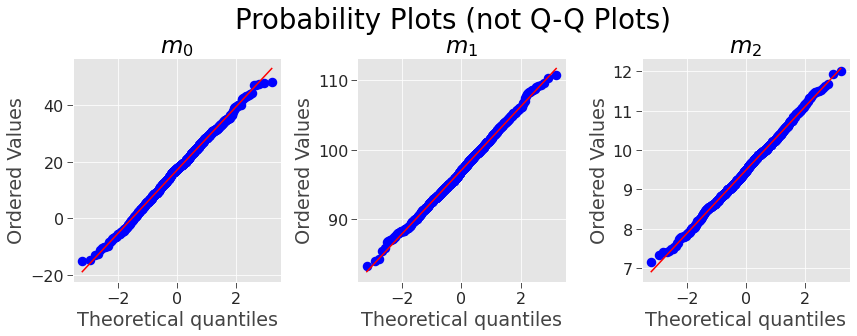

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(w_pad=1.5)

n_params = 3
for i_parm in range(n_params):
    ax = axes[i_parm]
    _ = stats.probplot(m_MC[:, i_parm], plot=ax)
    ax.set(title=f'$m_{i_parm}$')

fig.suptitle('Probability Plots (not Q-Q Plots)', y=1.1, fontsize='xx-large');